Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [126]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Dataset

In [127]:
df = pd.read_csv('CleanHospitalDatasetMultiAttributes.csv', encoding='utf8', dtype=object)

In [128]:
df.head()

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10022,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,35960,CHEROKEE,2569275531,Voluntary non-profit - Private,Surgical Infection Prevention,2 patients,1.0
1,10035,CULLMAN REGIONAL MEDICAL CENTER,1912 ALABAMA HIGHWAY 157,CULLMAN,35058,CULLMAN,2567372000,Government - Hospital District or Authority,Pneumonia,138 patients,1.0
2,10027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,36323,COFFEE,3348972257,Voluntary non-profit - Other,Surgical Infection Prevention,0 patients,1.0
3,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,36278,RANDOLPH,2563572111,Government - Local,Surgical Infection Prevention,0 patients,1.0
4,10050,ST VINCENTS BLOUNT,150 GILBREATH DRIVE,ONEONTA,35121,BLOUNT,2052743000,Voluntary non-profit - Private,Heart Attack,2 patients,1.0


In [129]:
len(df)

1100

In [130]:
df.columns.values

array(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'ZipCode',
       'CountyName', 'PhoneNumber', 'HospitalOwner', 'Condition',
       'Sample', 'label'], dtype=object)

## Data Cleaning

In [131]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10022,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,35960,CHEROKEE,2569275531,Voluntary non-profit - Private,Surgical Infection Prevention,2 patients,1.0
1,10035,CULLMAN REGIONAL MEDICAL CENTER,1912 ALABAMA HIGHWAY 157,CULLMAN,35058,CULLMAN,2567372000,Government - Hospital District or Authority,Pneumonia,138 patients,1.0


In [132]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [133]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10022,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,35960,CHEROKEE,2569275531,Voluntary non-profit - Private,Surgical Infection Prevention,2 patients,1.0
1,10035,CULLMAN REGIONAL MEDICAL CENTER,1912 ALABAMA HIGHWAY 157,CULLMAN,35058,CULLMAN,2567372000,Government - Hospital District or Authority,Pneumonia,138 patients,1.0


In [134]:
ProviderNumber = df['ProviderNumber'].tolist()
HospitalName = df['HospitalName'].tolist()
Address1 = df['Address1'].tolist()
City = df['City'].tolist()
ZipCode = df['ZipCode'].tolist()
CountyName = df['CountyName'].tolist()
PhoneNumber = df['PhoneNumber'].tolist()
Owner = df['HospitalOwner'].tolist()
Condition = df['Condition'].tolist()
Sample = df['Sample'].tolist()

In [135]:
values = [ProviderNumber, HospitalName, Address1, City, ZipCode, CountyName, PhoneNumber, Owner, Condition, Sample]
attributes = ['ProviderNumber', 'HospitalName', 'Address1', 'City','ZipCode','CountyName','PhoneNumber', 'HospitalOwner', 'Condition', 'Sample']

Create value, attribute-name tuple pairs

In [136]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [137]:
len(data)

11000

In [138]:
data[:10]

[['10022', 'ProviderNumber'],
 ['10035', 'ProviderNumber'],
 ['10027', 'ProviderNumber'],
 ['10032', 'ProviderNumber'],
 ['10050', 'ProviderNumber'],
 ['10015', 'ProviderNumber'],
 ['10001', 'ProviderNumber'],
 ['10032', 'ProviderNumber'],
 ['10015', 'ProviderNumber'],
 ['10001', 'ProviderNumber']]

In [139]:
data[-10:]

[['90 patients', 'Sample'],
 ['0 patients', 'Sample'],
 ['14 patients', 'Sample'],
 ['603 patients', 'Sample'],
 ['14 patients', 'Sample'],
 ['12 patients', 'Sample'],
 ['98 patients', 'Sample'],
 ['0 patients', 'Sample'],
 ['54 patients', 'Sample'],
 ['191 patients', 'Sample']]

In [140]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [141]:
dfData.head(2)

,Value,Label
0,10022,ProviderNumber
1,10035,ProviderNumber


In [142]:
dfData.tail()

,Value,Label
10995,12 patients,Sample
10996,98 patients,Sample
10997,0 patients,Sample
10998,54 patients,Sample
10999,191 patients,Sample


Convert labels to categorical attributes

In [143]:
dfData['Label'] = dfData['Label'].astype('category')

In [144]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [145]:
dfData.tail()

,Value,Label,Label_Cat
10995,12 patients,Sample,8
10996,98 patients,Sample,8
10997,0 patients,Sample,8
10998,54 patients,Sample,8
10999,191 patients,Sample,8


In [146]:
dfData['Label_Cat'].value_counts()

7    1100
6    1100
5    1100
4    1100
3    1100
2    1100
9    1100
1    1100
8    1100
0    1100
Name: Label_Cat, dtype: int64

Get the mapping

In [147]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [148]:
mapping

{0: 'Address1',
 1: 'City',
 2: 'Condition',
 3: 'CountyName',
 4: 'HospitalName',
 5: 'HospitalOwner',
 6: 'PhoneNumber',
 7: 'ProviderNumber',
 8: 'Sample',
 9: 'ZipCode'}

Drop the Label column

In [149]:
dfData.drop(['Label'], axis=1, inplace=True)

In [150]:
dfData.head()

,Value,Label_Cat
0,10022,7
1,10035,7
2,10027,7
3,10032,7
4,10050,7


Shuffle the data

In [151]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [152]:
dfData.head(10)

,Value,Label_Cat
0,Proprietary,5
1,ELBA GENERAL HOSPITAL,4
2,3343470584,6
3,619 SOUTH 19TH STREET,0
4,1725 PINE STREET,0
5,10007,7
6,Proprietary,5
7,MONTGOMERY,3
8,10016,7
9,139 patients,8


Find the longest string in the value column

In [153]:
dfData.Value.map(lambda x: len(str(x))).max()

43

In [154]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [155]:
batchSize = 32
maxSequenceLength = 200
maxWords = 5000

In [156]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 632 unique tokens.


In [157]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [158]:
labels = np.asarray(y)

In [159]:
data.shape

(11000, 200)

In [160]:
labels.shape

(11000,)

In [161]:
labels = to_categorical(labels)

In [162]:
labels.shape

(11000, 10)

Shuffle the dataset

In [163]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [164]:
data = data[indices]
labels = labels[indices]

## Train test split

In [165]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [166]:
len(X_train), len(y_train)

(8800, 8800)

In [167]:
len(X_test), len(y_test)

(2200, 2200)

## Model

In [168]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [169]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(10, activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [170]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                640032    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 1,142,794
Trainable params: 1,142,794
Non-trainable params: 0
_________________________________________________________________


In [171]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32, 
                    validation_split=0.2)

Train on 7040 samples, validate on 1760 samples
Epoch 1/5
7040/7040 [==============================] - 3s 426us/step - loss: 1.5366 - acc: 0.4788 - val_loss: 0.5614 - val_acc: 0.9006
Epoch 2/5
7040/7040 [==============================] - 3s 365us/step - loss: 0.3051 - acc: 0.9359 - val_loss: 0.1106 - val_acc: 0.9727
Epoch 3/5
7040/7040 [==============================] - 3s 369us/step - loss: 0.0690 - acc: 0.9831 - val_loss: 0.0564 - val_acc: 0.9892
Epoch 4/5
7040/7040 [==============================] - 2s 353us/step - loss: 0.0360 - acc: 0.9855 - val_loss: 0.0238 - val_acc: 0.9898
Epoch 5/5
7040/7040 [==============================] - 2s 351us/step - loss: 0.0279 - acc: 0.9842 - val_loss: 0.0268 - val_acc: 0.9903


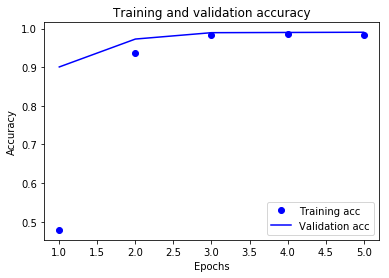

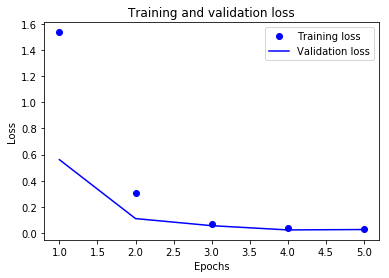

In [172]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [173]:
results = model.evaluate(X_test, y_test)

2200/2200 [==============================] - 0s 77us/step


In [174]:
loss = results[0]
accuracy = results[1]

In [175]:
loss

0.03414120212535966

In [176]:
accuracy

0.9868181818181818

Save the model

In [177]:
model.save("HospitalMultiAttributeClassifier.h5")

Save the tokenizer

In [178]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [179]:
model = load_model('HospitalMultiAttributeClassifier.h5')

In [180]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [184]:
testString = ['36278']

In [185]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=200)

In [186]:
predictions = model.predict(testData)

In [187]:
mapping[np.argmax(predictions[0])]

'ZipCode'